# Muestreo de distribuciones generales

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG" width="400px" height="400px" />

> Ya nos hicimos una idea básica de lo que es la estimación Montecarlo. Vimos que es fundamental poder muestrear las distribuciones, y por ello vimos métodos para muestrear distribuciones en una dimensión, tanto discretas como continuas.

> Ahora, ¿Qué pasa si nuestra distribución es multivariable? Bien, en este notebook estaremos viendo métodos generales para muestrear cualquier distribución através de cadenas de Markov.

> **Objetivos:**
> - Estudiar las cadenas de Markov, sus componentes y propiedades básicas.
> - Entender las cadenas de Markov como artefactos para muestrar distribuciones.
> - Comprender la técnica de muestreo de Gibbs.
> - Comprender la técnica de muestreo de Metropolis-Hastings.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 12.

<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG.</p>

___

## 1. Cadenas de Markov

Una cadena de Markov es un **modelo de transiciones probabilístico** sobre ciertos estados $x$. Para ello definimos la probabilidad de transicionar de un estado $x$ a otro estado $x'$ como $T(x \to x')$, y al ser una probabilidad debe cumplir que:

$$
\forall x: \sum_{x'}T(x \to x') = 1.
$$

#### Ejemplo.

Consideramos la trayectoria de un borracho modelada por la siguiente cadena de Markov:

![](figures/drunkMC.png)

Cada arco representa la probabilidad de transicionar de un estado a otro (incluyendo al mismo estado de partida). Por ejemplo, en la cadena de Markov de arriba:

$$
T(0 \to 0) = 0.5, \quad T(0 \to 1) = 0.25, \quad T(0 \to -1) = 0.25.
$$

Es decir, si el borracho está en la posición $0$, tiene un 50% de probabilidad de permanecer allí, y un 25% de moverse a las posiciones $1$ y $-1$.

Una pregunta natural es:

- En determinado instante $t$, ¿Cuál es la probabilidad $p^{(t)}(x^{(t)})$ de que el borracho esté en determinada posición?

La respuesta es:

- Dada una distribución inicial de probabilidad $p^{(0)}(x^{(0)})$, podemos encontrar $p^{(t)}(x^{(t)})$ como:

  $$
  p^{(t+1)}(x^{(t+1)} = x') = \sum_{x} p^{(t)}(x^{(t)}) T(x \to x').
  $$

Por ejemplo, si sabemos que el borracho comenzó en la posición $0$, tenemos que:

| $p^{(t)}(x^{(t)})$ | $x^{(t)}=-2$ | $x^{(t)}=-1$ | $x^{(t)}=0$ | $x^{(t)}=1$ | $x^{(t)}=2$ |
| ------------------ | ------------ | ------------ | ----------- | ----------- | ----------- |
| $p^{(0)}(x^{(0)})$ | $0$          | $0$          | $1$         | $0$         | $0$         |
| $p^{(1)}(x^{(1)})$ | $0$          | $0.25$       | $0.5$       | $0.25$      | $0$         |
| $p^{(2)}(x^{(2)})$ | $0.0625$     | $0.25$       | $0.375$     | $0.25$      | $0.0625$    |

**Explicar estos valores en el pizarrón.**

Esta tabla la podemos continuar todo lo que queramos, y veremos que después de algunas iteraciones **todos los valores convergerán a $0.2$**.

In [1]:
# Importamos numpy
import numpy as np

In [2]:
# Matriz de transición
T = np.array([[0.75, 0.25, 0.00, 0.00, 0.00],
              [0.25, 0.50, 0.25, 0.00, 0.00],
              [0.00, 0.25, 0.50, 0.25, 0.00],
              [0.00, 0.00, 0.25, 0.50, 0.25],
              [0.00, 0.00, 0.00, 0.25, 0.75]])

# Distribución inicial
P0 = np.array([0, 0, 1, 0, 0])

In [3]:
# Distribución 1
P1 = T.dot(P0)
P1

array([0.  , 0.25, 0.5 , 0.25, 0.  ])

In [4]:
# Distribución 2
P2 = T.dot(P1)
P2

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])

In [5]:
P2 = T.dot(T.dot(P0))
P2

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])

In [6]:
np.linalg.matrix_power?

In [7]:
# Distribución 100
P100 = np.linalg.matrix_power(T, 100).dot(P0)
P100

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [8]:
# Distribución 100
P1000 = np.linalg.matrix_power(T, 1000).dot(P0)
P1000

array([0.2, 0.2, 0.2, 0.2, 0.2])

**¿Cómo podemos interpretar esto?**

Supongamos que dejamos caminar al borracho durante varios pasos (digamos 1000) y obtenemos la siguiente secuencia:

$$
0, 0, 1, 2, 1, \dots, -1
$$

Podemos hacer lo mismo repetidas veces:

$$
0, 1, 1, 0, 1, \dots, 2
$$

$$
0, 1, 0, -1, 0, \dots, 0
$$

$$
0, 1, 0, -1, -2, \dots, 1
$$

$$
0, -1, -2, -2, -1, \dots, -2
$$

Entonces, podemos tomar las últimas observaciones en cada caso ($-1$, $2$, $0$, $1$, y $-2$) que corresponden a muestras de la distribución del paso número 1000 dado que el borracho comenzó en la posición 0.

Como vimos anteriormente, estas muestras corresponderán a la distribución discreta uniforme:

$$
p(x = i) = 0.2, \quad \forall i \in \{-2, -1, 0, 1, 2\}.
$$

Esta es una manera muy extravagante de generar muestras de esta distribución, pues ya vimos en el notebook pasado que hay maneras mucho más sencillas de hacerlo.

Sin embargo, esto nos da una idea de qué hacer en casos más complejos: **podemos construir una cadena de markov que converja a una distribución deseada y después tomar las muestras de allí**.

Es decir, queremos muestrear de una distribución $p(x)$:

1. Construimos una cadena de Markov que converge a $p(x)$.

2. Comenzamos desde algún punto inicial $x_0$.

3. Simulamos la cadena de Markov por muchas muestras:
   
   $$
   x_k \sim T(x_{k-1} \to x_k)
   $$
   
4. Si dejamos pasar suficientes muestras, las siguientes $x_k$ corresponderán a muestras de la distribución deseada $p(x)$.

Una pregunta natural es:

**¿Siempre converge una cadena de Markov?**

La respuesta es no siempre.

Para empezar a hablar de convergencia, primero definimos:

> *Definición.* Una distribución $\pi$ es estacionaria en la cadena de Markov con transición $T$ si:
>
> $$\pi(x') = \sum_{x} \pi(x) T(x \to x').$$

Básicamente si de un instante de tiempo al siguiente la distribución no cambia, entocnes es estacionaria.

> *Definition (Regular Markov chain).* Una cadena de Markov se llama **regular** si existe $k\in\mathbb{N}$ tal que, para cada par $x, x'$, la probabilidad de llegar de $x$ a $x'$ en $k$ pasos es positiva ($>0$).

> *Teorema.* Una cadena de Markov regular converge siempre a una única distribución $\pi(x)$ sin importar la distribución inicial.

Por ejemplo, la cadena de Markov del borracho es regular:

In [11]:
# Distribución inicial diferente
P0 = np.array([0.25, 0, 0, 0, 0.75])
P1000 = np.linalg.matrix_power(T, 1000).dot(P0)
P1000

array([0.2, 0.2, 0.2, 0.2, 0.2])

Entonces ya sabemos definir cadenas de Markov convergentes. Ahora, **¿Cómo hacer para que converjan a una distribución deseada?**

## 2. Muestreo de Gibbs

Para responder a la anterior pregunta, surge la metodología del muestreo de Gibbs.

Supongamos que tenemos una distribución (no normalizada) de tres dimensiones (puede tener dimensiones arbitrarias):

$$
p(x_1, x_2, x_3) = \frac{\tilde{p}(x_1, x_2, x_3)}{Z}
$$

**Idea:**

1. Comenzamos con un punto inicial $(x_1^0, x_2^0, x_3^0)$.

2. Muestreamos de la siguiente manera:

   $$
   x_1^1 \sim p(x_1 | x_2^0, x_3^0)
   $$
   
   $$
   x_2^1 \sim p(x_2 | x_1^1, x_3^0)
   $$
   
   $$
   x_3^1 \sim p(x_3 | x_1^1, x_2^1)
   $$
   
   - Notemos que vamos reemplazando las muestras que vamos generando inmediatamente. No se puede paralelizar.
   - Muestreo de distribuciones unidimensionales.
   - Si conocemos solo la distribución no normalizada, no hay problema: $p(x_1 | x_2^0, x_3^0) = \frac{\tilde{p}(x_1, x_2^0, x_3^0)}{Z_1}$

3. Y así sucesivamente:

   $$
   x_1^{k} \sim p(x_1 | x_2^{k-1}, x_3^{k-1})
   $$
   
   $$
   x_2^{k} \sim p(x_2 | x_1^{k}, x_3^{k-1})
   $$
   
   $$
   x_3^{k} \sim p(x_3 | x_1^{k}, x_2^{k})
   $$

### ¿Por qué funciona?

Veámoslo desde el punto de vista de redes de Markov. Queremos probar que $p$ es una distribución estacionaria:

$$
p(x', y', z') = \sum_{x, y, z} T(x, y, z \to x', y', z') p(x, y, z).
$$

Para el muestreo de Gibbs, tenemos que la transición es:

$$
T(x, y, z \to x', y', z') = p(x' | y, z) p(y' | x', z) p(z' | x', y').
$$

Concentrémonos en el lado derecho de la igualdad:

\begin{align}
\sum_{x, y, z} p(x' | y, z) p(y' | x', z) p(x, y, z) & =  p(z' | x', y')\sum_{y, z} p(x' | y, z) p(y' | x', z) \underbrace{\sum_{x} p(x, y, z)}_{p(y, z)} \\
& = p(z' | x', y')\sum_{z} p(y' | x', z) \underbrace{\sum_{y} \underbrace{p(x' | y, z) p(y, z)}_{p(x', y, z)}}_{p(x', z)} \\
& = p(z' | x', y')\underbrace{\sum_{z} \underbrace{p(y' | x', z) p(x', z)}_{p(x', y', z)}}_{p(x', y')} \\
& = p(z' | x', y')p(x', y') \\
& = p(x', y', z').
\end{align}

Tal y como queríamos.

**Comentarios:**

- Esta misma idea se puede replicar para un número arbitrario de dimensiones.

- También funciona en el caso continuo, reemplazando sumas por integrales.

### Ejemplo

Tomado del [siguiente enlace](https://towardsdatascience.com/gibbs-sampling-8e4844560ae5)

Supongamos que queremos muestrear la siguiente distribución:

$$
p(x, y) = \frac{1}{Z} \exp \left\{- \frac{x^2 y^2 + x^2 + y^2 - 8x - 8y}{2} \right\}
$$

In [12]:
# Importamos matplotlib.pyplot
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
# Importamos numpy
import numpy as np

In [13]:
def rare_pdf(x, y):
    return np.exp(-(x**2 * y**2 + x**2 +y**2 - 8 * x - 8 * y) / 2)

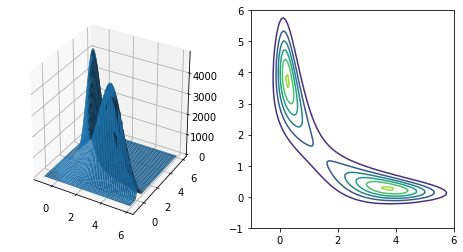

In [14]:
# Gráfico
x = np.linspace(-1, 6, 100)
y = np.linspace(-1, 6, 100)
x, y = np.meshgrid(x, y)
z = rare_pdf(x, y)
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, z)

ax2 = fig.add_subplot(122)
ax2.contour(x, y, z)
plt.show()

Recordemos que necesitamos las distribuciones condicionales:

$$
p(x | y) = \frac{p(x, y)}{p(y)} = \frac{1}{Z(y)} \exp\left\{-\left(x - \frac{4}{1 + y^2}\right)^2 \frac{1}{2\frac{1}{1+y^2}}\right\} \propto \mathcal{N}\left(x\left\lvert \frac{4}{1 + y^2}, \frac{1}{1 + y^2}\right.\right)
$$

$$
p(y | x) = \frac{p(x, y)}{p(x)} = \frac{1}{Z(x)} \exp\left\{-\left(y - \frac{4}{1 + x^2}\right)^2 \frac{1}{2\frac{1}{1+x^2}}\right\} \propto \mathcal{N}\left(y\left\lvert \frac{4}{1 + x^2}, \frac{1}{1 + x^2}\right.\right)
$$

In [15]:
# Punto inicial
x0 = np.array([0, 0])

In [16]:
def gibbs_sampling(x0, M):
    
    # Prealloc de variables
    xs = np.zeros((M + 1, len(x0)))
    xs[0, :] = x0
    
    for k in range(M):
        xk, yk = xs[k, :]
        
        # Muestreamos x^{k+1} de la condicional p(x | y^{k})
        mean_x = 4 / (1 + yk**2)
        std_x = (1 / (1 + yk**2))**0.5
        xk1 = std_x * np.random.randn() + mean_x
        
        # Muestreamos y^{k+1} de la condicional p(y | x^{k+1})
        mean_y = 4 / (1 + xk1**2)
        std_y = (1 / (1 + xk1**2))**0.5
        yk1 = std_y * np.random.randn() + mean_y
        
        # Guardamos siguiente muestra
        xs[k + 1, 0] = xk1
        xs[k + 1, 1] = yk1
        
    return xs

In [17]:
xs = gibbs_sampling(x0, 1000)

In [18]:
xs

array([[ 0.        ,  0.        ],
       [ 4.17223305,  0.07840334],
       [ 3.43623767, -0.03901566],
       ...,
       [ 0.42781347,  1.6986532 ],
       [ 0.58609345,  2.97454718],
       [ 0.33084169,  3.96502911]])

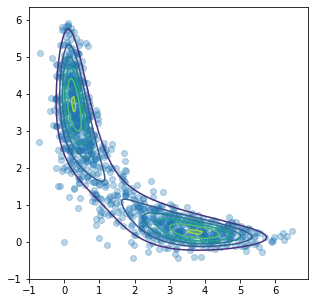

In [19]:
# Gráfico
plt.figure(figsize=(5, 5))
x = np.linspace(-1, 6, 100)
y = np.linspace(-1, 6, 100)
x, y = np.meshgrid(x, y)
z = rare_pdf(x, y)
plt.contour(x, y, z)
plt.scatter(xs[:, 0], xs[:, 1], alpha=0.3)
plt.show()

Como idea importante, podemos observar que nunca conocimos la distribución $p(x,y)$ normalizada.

## 3. Metropolis-Hastings

El muestreo de Gibbs parece hacer un buen trabajo. Sin embargo, por la manera en que se obtienen las muestras, éstas están muy correlacionadas, y recordemos que muchos análisis los basamos en el supuesto de iid.

Así que en esta sección estudiaremos un método para producir muestras no correlacionadas. La idea básica de este método es generalizar la técnica de muestreo y rechazo para distribuciones en general.

**Idea**

1. Comenzamos con un punto inicial $(x_1^0, x_2^0, x_3^0)$.

2. Muestreamos $x^{k+1}$ de una distribución $Q(x^{k} \to x')$, que en principio no tiene nada que ver con la distribución deseada $p(x)$, sino que está diseñada para explorar el espacio (evitar correlación).

3. Aceptamos la muestra $x'$ con probabilidad $A(x^{k} \to x')$.
   - Dado que $Q(x^{k} \to x')$ quiere explorar tooodo el espacio, debemos evitar que muchas muestras caigan en una región de baja probabilidad de la distribución deseada $p(x)$.
   
   De manera que la transición es:
   $$
   T(x \to x') = Q(x \to x') A(x \to x').
   $$
   
   - Si no se acepta la muestra, hacemos $x^{k+1}=x^k$

**¿Cómo elegimos la probabilidad de aceptación $A(x \to x')$?**

Bueno, pues debemos de asegurarnos que la distribución deseada $p(x)$ sea estacionaria:

$$
p(x') = \sum_{x} p(x) T(x \to x').
$$

Sin embargo esta condición es compleja de satisfacer directamente, e involucraría restricciones sobre $A$ y $Q$.

La idea es que se elija $Q$ independientemente, y después de eso, diseñar $A$ para que todo funcione correctamente.

Hay una condición que implica estacionariedad, y es la siguiente:

> *Teorema*. Si $p(x) T(x \to x') = p(x') T(x' \to x)$, entonces
  $$
p(x') = \sum_{x} p(x) T(x \to x').
$$

> *Prueba.*
> Observamos que
  $$
  \sum_{x} p(x) T(x \to x') = \sum_{x} p(x') T(x' \to x) = p(x') \underbrace{\sum_x T(x' \to x)}_{1}.
  $$

Por tanto, si elegimos $A$ de manera que se satisfaga $p(x) T(x \to x') = p(x') T(x' \to x)$, aseguraremos que $p(x)$ sea la distribución estacionaria deseada.

Veamos:

\begin{align}
            & p(x) T(x \to x') = p(x') T(x' \to x) \\
\Rightarrow & p(x) Q(x \to x') A(x \to x') = p(x') Q(x' \to x) A(x' \to x) \\
\Rightarrow & \frac{A(x \to x')}{A(x' \to x)} = \frac{p(x') Q(x' \to x)}{p(x) Q(x \to x')} = \rho
\end{align}

Esta razón la podemos calcular dado que $p(x)$ es la distribución deseada, y $Q$ la proponemos nosotros.

Ahora, tenemos dos posibildades:

1. $\rho \leq 1$ 

   En este caso, podemos asignar:
   
   $$
   A(x \to x') = \rho, \quad A(x' \to x)=1,
   $$
   
   de modo que $\frac{A(x \to x')}{A(x' \to x)} = \rho$.
   
2. $\rho > 1$ 

   En este caso, podemos asignar:
   
   $$
   A(x \to x') = 1, \quad A(x' \to x)=\frac{1}{\rho},
   $$
   
   de modo que $\frac{A(x \to x')}{A(x' \to x)} = \rho$.
   
   
De esta manera, la selección de $A$ será en general:

$$
A(x \to x') = \min \left\{1, \frac{p(x') Q(x' \to x)}{p(x) Q(x \to x')}\right\}
$$

De nuevo, observamos que con esta selección, no necesitamos conocer $p(x)$ normalizada, dado en la razón se cancela la constante de normalización.

**Importante**

1. $Q$ debe ser una distribución **positiva**.

2. Debemos elegir $Q$ para explorar el espacio de estados exhaustivamente, para generar muestras independientes. Sin embargo, si $Q$ explora mucho las regiones de baja densidad de $p$ entonces tendremos poca probabilidad de aceptación.

### Ejemplo

De nuevo, queremos muestrear la distribución:

$$
p(x_1, x_2) = \frac{1}{Z} \exp \left\{- \frac{x_1^2 x_2^2 + x_1^2 + x_2^2 - 8x_1 - 8x_2}{2} \right\}
$$

Proponemos la siguiente distribución $Q(x \to x')$:

$$
Q(x \to x') = \mathcal{N}\left(x'\left\lvert x, I\right.\right) = \mathcal{N}\left(x\left\lvert x', I\right.\right) = Q(x' \to x),
$$

la cual es simétrica.

De esta manera tenemos que:

$$
A(x \to x') = \min \left\{1, \frac{p(x') Q(x' \to x)}{p(x) Q(x \to x')}\right\} = \min \left\{1, \frac{p(x')}{p(x)}\right\}
$$

In [20]:
# Punto inicial
x0 = np.array([0, 0])

In [21]:
from scipy.stats import multivariate_normal

In [23]:
def metropolis_hastings(x0, M):
    
    # Prealloc de variables
    xs = np.zeros((M + 1, len(x0)))
    xs[0, :] = x0
    
    for k in range(M):
        xk = xs[k, :]
        
        # Muestreamos x' de Q(x -> x')
        xp = multivariate_normal.rvs(mean=xk, cov=1 * np.eye(2))
        
        # Evaluamos A
        A = min(1, rare_pdf(xp[0], xp[1]) / rare_pdf(xk[0], xk[1]))
        
        # Guardamos siguiente muestra
        if np.random.rand() < A:
            xs[k + 1, :] = xp
        else:
            xs[k + 1, :] = xk
        
    return xs

In [29]:
xs = metropolis_hastings(x0, 1000)

In [30]:
xs

array([[ 0.        ,  0.        ],
       [-0.04209952,  0.22940399],
       [-0.04209952,  0.22940399],
       ...,
       [ 0.1578592 ,  4.67640338],
       [ 0.1578592 ,  4.67640338],
       [ 0.11026797,  5.46752696]])

¿Cuántos no repetidos?

In [31]:
xsu = np.unique(xs, axis=0)

In [32]:
xsu.shape

(341, 2)

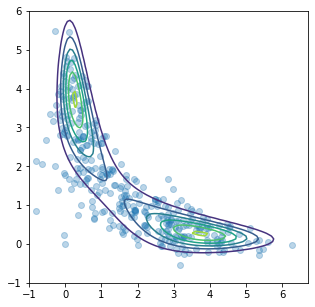

In [33]:
# Gráfico
plt.figure(figsize=(5, 5))
x = np.linspace(-1, 6, 100)
y = np.linspace(-1, 6, 100)
x, y = np.meshgrid(x, y)
z = rare_pdf(x, y)
plt.contour(x, y, z)
plt.scatter(xsu[:, 0], xsu[:, 1], alpha=0.3)
plt.show()

¿Cómo cambian los $x_s$ con la variabilidad de $Q$?

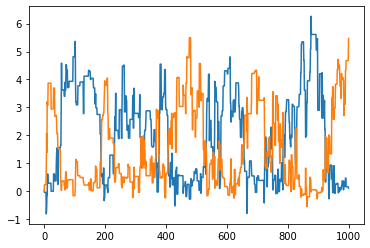

In [34]:
plt.plot(xs)

**Comentarios**

1. Similarmente, no necesitamos conocer la distribución normalizada.

2. Es una generalización del algoritmo de muestreo y rechazo para distribuciones en general.

3. Mucho más fácil de implementar que el muestreo de Gibbs, dado que no tenemos que calcular las distribuciones condicionales.

4. Pero debemos elegir una distribución $Q$ apropiada.

## 4. Comentarios finales MCMC

Los métodos Monte Carlo son acerca de estimar valores esperados. Vimos que:

> Dada una distribución $p$ y una función $f$,
>
> $$\mathbb{E}_p(x)[f(x)] \approx \frac{1}{M} \sum_{s=1}^{M}f(x_s),$$
>
> donde $\{x_s\}_{s=1}^{M}$ son muestras iid. de la distribución $p(x)$.

Como el promedio es un estimador no sesgado de la media, estos métodos funcionan bastante bien para tamaños de muestra $M$ grandes.

La parte de cadenas de Markov, vimos que era bastante útil para generar muestras de distribuciones (no normalizadas) en general.

**Este es un paradigma para hacer inferencia aproximada completamente distinta a la inferencia variacional**.

En inferencia variacional, lo que hacemos es aproximar la distribución $p(x)$ con una distribución variacional $q(x)$ (distribución factorizada) e intentamos lo siguiente:

$$
p(x) \approx q(x) \Rightarrow \mathbb{E}_p(x)[f(x)] \approx \mathbb{E}_q(x)[f(x)] .
$$

Sin embargo, en este tipo de aproximaciones no podemos llevar el error a cero, dado que no podemos aproximar arbitrariamente bien una distribución con otra familia de distribuciones en general.

Mientras que, por otra parte, sí podemos seguir generando más y más muestras, y así hacer que la aproximación Monte Carlo sea cada vez mejor. La única restricción es: **paciencia**.

Es decir, la inferencia variacional es *más rápida*, pero MCMC nos puede dar mejores resultados en el largo plazo.

Entonces, complementando nuestro arsenal de técnicas para inferencia:

1. Inferencia completa: cálculo exacto de $p(T, \theta | X)$.
   - Aproximación campo media: $p(T, \theta | X) \approx q(T) q(\theta)$.
   - MCMC: $T_s, \theta_s \sim p(T, \theta | X)$.
2. Algoritmo ME: $q(T)$ y $\theta = \theta_{ML}$.
   - ME variacional: $q_1(T_1) \cdot \dots \cdot q_d(T_d)$ y $\theta = \theta_{ML}$.
   - ME MCMC: $T_s \sim q(T)$ y $\theta = \theta_{ML}$.

Mientras más abajo nos vamos tenemos algoritmos menos precisos.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>